## Bark Texture Images Classification
BarkVN-50 consists of 50 categories of bark texture images. Total number is 5,578 images with 303× 404 pixels.
Trasnfer Learning has been applied here for the image classification. ResNet50 model was used.

ResNet-50 is a convolutional neural network that is 50 layers deep. A pretrained version of the network is trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224. 

### Import the neccessary packages
1. numpy has been used to process the images
2. matplotlib is used to plot the data 
3. tensorflow has been used for the ImageDataGenerator for Data Augmentation
4. keras has been used to create a basic neural network architecture that can go along with ResNet50
5. accuracy_score has been used as a metric of evaluation
6. PIL has been used to process the images
7. os has been used to traverse the input directory

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
from numpy import asarray
import os
from tensorflow.keras.applications.resnet50 import ResNet50

Input format is a folder containing 50 sub-folders representing each bark texture with their corresponding images.
This folder has been processed, the images resized to 32 x 32 x 3 to avoid memory issues, and converted to X that has all the image vectors and y having the corresponding classes.

The dependent variable has not been encoded. They have been treated as it is.

### Get the list of classes

In [26]:
classes = []
root = '../input/barkvn50/BarkVN-50/BarkVN-50_mendeley'
for folder in os.listdir(root):
    classes.append(str(folder))
print(len(classes))

50


### Create X and y

In [27]:
y = []
for i in range(len(classes)):
    cls = classes[i]
    folder = root + '/' + cls
    for file in os.listdir(folder):
#         img = Image.open(folder+ '/' + file)
#         numpydata = asarray(img)
#         X.append(numpydata)
        y.append(i)

y = np.array(y)        
        

In [28]:
file_list = []
for i in range(len(classes)):
    cls = classes[i]
    folder = root + '/' + cls
    for file in os.listdir(folder):
        img = folder+ '/' + file
        file_list.append(img)

In [29]:
X = []
for fname in file_list:
    image = Image.open(fname)
    image = image.resize((32,32),Image.ANTIALIAS)
    X.append(np.array(image))

X = np.array(X)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


In [30]:
X.shape, y.shape

((5578, 32, 32, 3), (5578,))

### Shuffle and plit this dataset into train and test with 25% test ratio

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.25, random_state = 42)

1


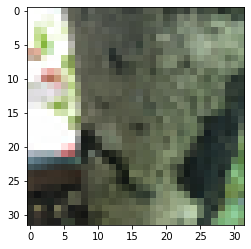

In [32]:
plt.imshow(X[100])
print(y[100])

26


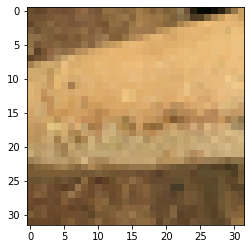

In [33]:
plt.imshow(X_train[100])
print(Y_train[100])

In [34]:
X_train[0] = X_train[0]/255
X_train.shape

(4183, 32, 32, 3)

In [35]:
Y_train[12]

24

### Plot the images

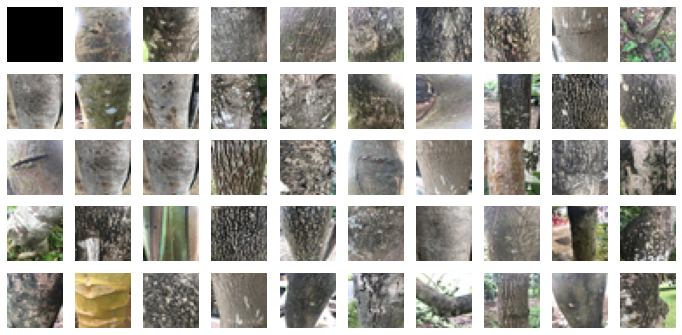

In [36]:
plt.figure(figsize=(12,12))
for i in range(50):
    plt.subplot(10,10,1+i)
    plt.axis('off')
    plt.imshow(X_train[i],cmap='gray')

### We have also further split the training dataset to create a validation data that is used to validate our model performance during training

In [37]:
x_train,x_val,y_train,y_val = train_test_split(X_train, Y_train, test_size = 0.2)

### Normalize the data

In [38]:
x_train = x_train * 1.0/255
x_val = x_val * 1.0/255
X_test = X_test * 1.0/255

In [39]:
print(x_train.shape, x_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, Y_test.shape)

(3346, 32, 32, 3) (837, 32, 32, 3) (1395, 32, 32, 3)
(3346,) (837,) (1395,)


### Augment the data

In [40]:
train_datagen = ImageDataGenerator( 
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1,  
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,  
        vertical_flip = False
        )
train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 128)


In [41]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.6, 
    min_lr=1e-6)

### Create a ResNet50 model

In [42]:
resnet_model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [43]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Add the ResNet50 model to our neural network

In [44]:
model=tf.keras.models.Sequential()
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50, activation='softmax'))

In [45]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

In [46]:
model.compile(
    optimizer = optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [47]:
def timer(start_time=None):
  #function to track time 
  if not start_time:
      print(datetime.now())
      start_time = datetime.now()
      return start_time
  elif start_time:
      thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
      tmin, tsec = divmod(temp_sec, 60)
      print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [48]:
start_time=timer(None)
result=model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = (x_val, y_val),
    epochs = 150,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)
timer(start_time)

2022-09-27 08:29:19.438611


2022-09-27 08:29:20.662789: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-09-27 08:29:26.373160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
27/27 [==============================] - 21s 568ms/step - loss: 4.4157 - accuracy: 0.0392 - val_loss: 4.0467 - val_accuracy: 0.0239
Epoch 2/150
27/27 [==============================] - 14s 500ms/step - loss: 3.4329 - accuracy: 0.1635 - val_loss: 4.1142 - val_accuracy: 0.0370
Epoch 3/150
27/27 [==============================] - 13s 499ms/step - loss: 2.7868 - accuracy: 0.2989 - val_loss: 4.8823 - val_accuracy: 0.0263
Epoch 4/150
27/27 [==============================] - 13s 499ms/step - loss: 2.4001 - accuracy: 0.3951 - val_loss: 6.2002 - val_accuracy: 0.0239
Epoch 5/150
27/27 [==============================] - 14s 500ms/step - loss: 2.0942 - accuracy: 0.4561 - val_loss: 9.3199 - val_accuracy: 0.0466
Epoch 6/150
27/27 [==============================] - 13s 499ms/step - loss: 1.8921 - accuracy: 0.5117 - val_loss: 24.1966 - val_accuracy: 0.0466
Epoch 7/150
27/27 [==============================] - 13s 499ms/step - loss: 1.7049 - accuracy: 0.5652 - val_loss: 44.0556 - val_accurac

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, None, None, None)  0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 50)               

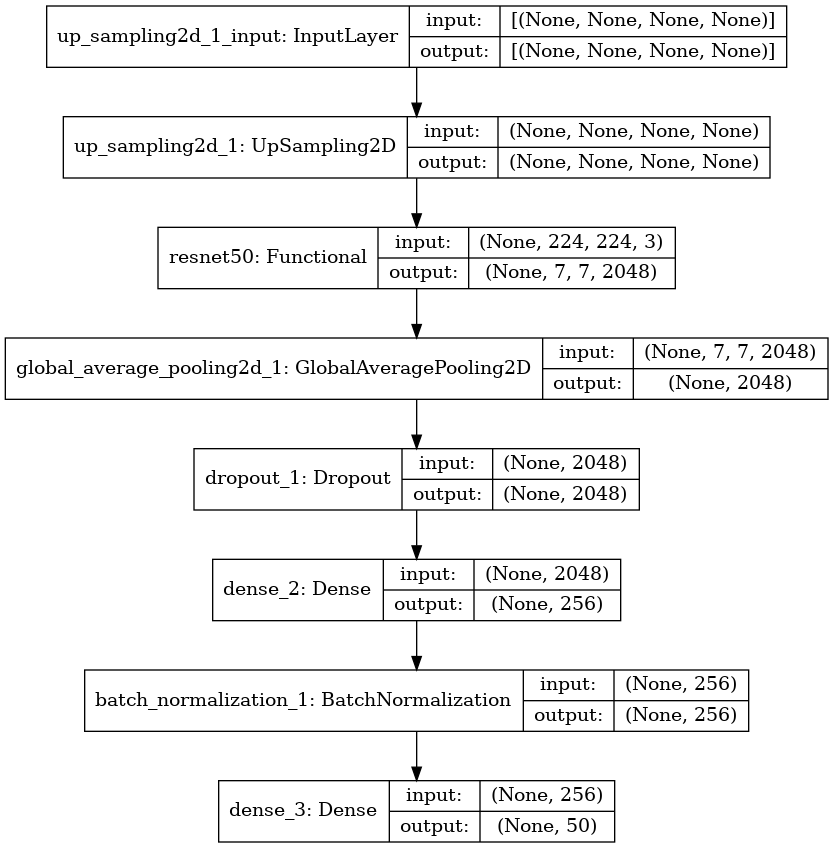

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [51]:
def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

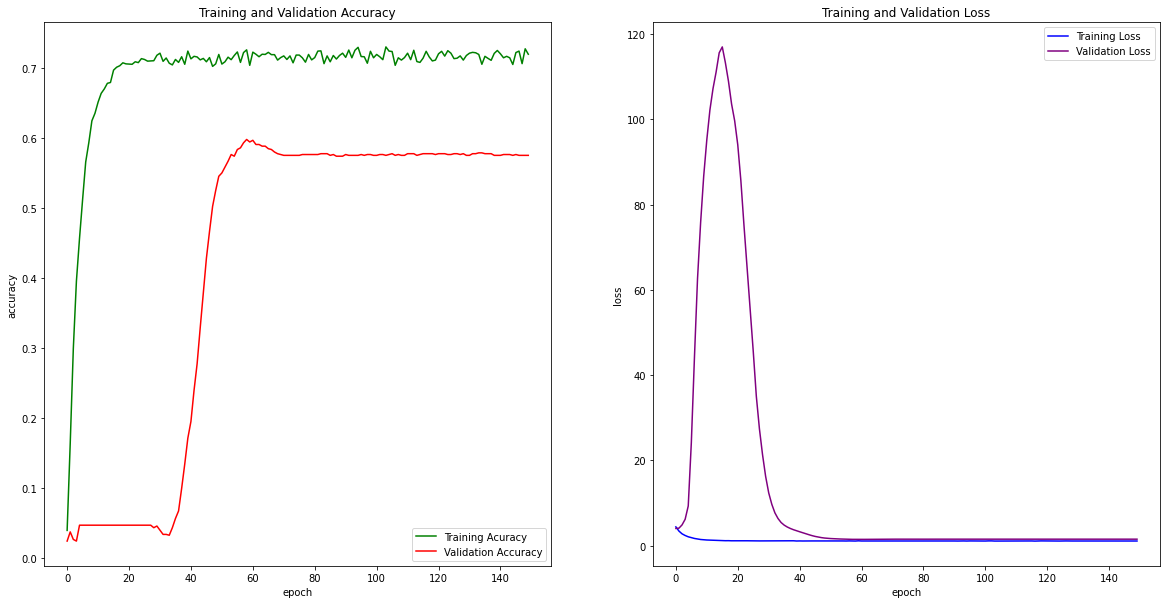

In [52]:
plot_acc_loss(result)

In [53]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = Y_test.ravel()
print(y_pred.shape,y_true.shape)

(1395,) (1395,)


In [54]:
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

Testing Accuracy:  0.5792114695340502


In [55]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[13,  0,  0, ...,  0,  0,  0],
       [ 0, 20,  0, ...,  0,  0,  0],
       [ 0,  0, 22, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  3,  0,  0],
       [ 0,  0,  7, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0, 23]])